<a href="https://colab.research.google.com/github/emilyberlinghoff/BikeShare/blob/main/flow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
from collections import defaultdict

def add_running_inflow_outflow_flow(input_csv: str, output_csv: str) -> None:
    """
    Reads a bike-share CSV (with columns including Start Station Id, End Station Id, Start Time, etc.),
    sorts rows by Start Time, and processes each trip in chronological order to maintain a running tally.

    For each row:
      - Increment outflow for that row's start station by 1
      - Increment inflow for that row's end station by 1

    Then add four columns to show, as of that row/trip:
      1) 'Total outflow of start station'
      2) 'Total inflow of end station'
      3) 'Total flow of start station' = inflow - outflow for the start station
      4) 'Total flow of end station'   = inflow - outflow for the end station

    Writes the updated DataFrame to output_csv.
    """

    # Read the CSV
    df = pd.read_csv(input_csv)

    # Sort by Start Time (assumes it's a valid datetime or sortable string).
    # Remove or adjust if you do not want chronological sorting.
    df.sort_values(by="Start Time", inplace=True)

    # Dictionaries to track how many bikes have flowed in/out for each station
    station_outflow = defaultdict(int)
    station_inflow = defaultdict(int)

    # We'll store these four columns per row in lists, then attach them to df
    total_outflow_of_start_station_list = []
    total_inflow_of_end_station_list = []
    total_flow_of_start_station_list = []
    total_flow_of_end_station_list = []

    # Go row by row in chronological order
    for _, row in df.iterrows():
        start_id = row["Start Station Id"]
        end_id = row["End Station Id"]

        # This trip departs start station -> increment that station's outflow
        station_outflow[start_id] += 1
        # This trip arrives at end station -> increment that station's inflow
        station_inflow[end_id] += 1

        # Now record the cumulative totals for these two stations
        outflow_of_start_station = station_outflow[start_id]
        inflow_of_end_station = station_inflow[end_id]

        # The total flow for a station is (inflow - outflow)
        flow_of_start_station = station_inflow[start_id] - station_outflow[start_id]
        flow_of_end_station = station_inflow[end_id] - station_outflow[end_id]

        # Append these values for the row
        total_outflow_of_start_station_list.append(outflow_of_start_station)
        total_inflow_of_end_station_list.append(inflow_of_end_station)
        total_flow_of_start_station_list.append(flow_of_start_station)
        total_flow_of_end_station_list.append(flow_of_end_station)

    # Attach the new columns
    df["Total outflow of start station"] = total_outflow_of_start_station_list
    df["Total inflow of end station"]   = total_inflow_of_end_station_list
    df["Total flow of start station"]   = total_flow_of_start_station_list
    df["Total flow of end station"]     = total_flow_of_end_station_list

    # Write out to a new CSV
    df.to_csv(output_csv, index=False)


if __name__ == "__main__":
    input_file = "Bike share ridership 2024-01.csv" # CHANGE THIS FOR EACH FILE
    output_file = "Flow 2024-01.csv" # CHANGE THIS FOR EACH FILE
    add_running_inflow_outflow_flow(input_file, output_file)
    print(f"Saved updated file with per-row inflow/outflow/flow columns to {output_file}")

Saved updated file with per-row inflow/outflow/flow columns to Flow 2024-01.csv


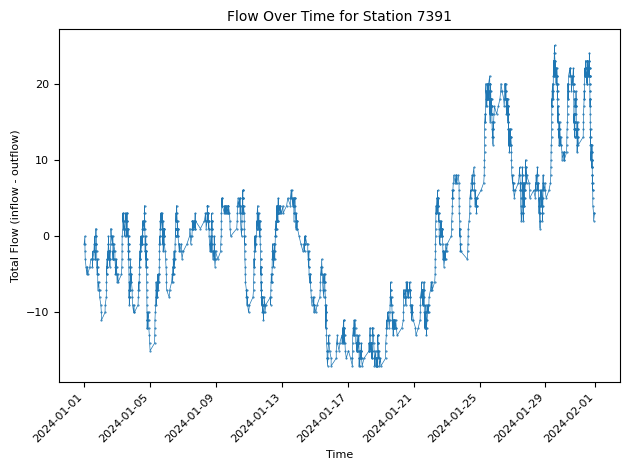

In [22]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_station_flow(csv_file: str, station_id: int) -> None:
    """
    Reads the CSV containing columns:
      - Start Station Id, End Station Id
      - Total flow of start station, Total flow of end station
      - Start Time
    Filters for the given station_id (either as start or end station),
    then plots its total flow over time, placing a small marker at each occurrence.
    """
    # 1. Read the CSV
    df = pd.read_csv(output_file) # CHANGE THIS IF YOU WANNA USE A DIFFERENT FLOW FILE

    # 2. Convert 'Start Time' to datetime so we can plot it properly
    df["Start Time"] = pd.to_datetime(df["Start Time"], errors="coerce")

    # 3. Filter rows where this station appears as start OR end
    df_station = df[(df["Start Station Id"] == station_id) | (df["End Station Id"] == station_id)].copy()

    # 4. For each row, pick which "Total flow" column applies to this station
    def get_station_flow(row):
        if row["Start Station Id"] == station_id:
            return row["Total flow of start station"]
        else:
            return row["Total flow of end station"]

    df_station["Station Flow"] = df_station.apply(get_station_flow, axis=1)

    # 5. Sort rows chronologically
    df_station.sort_values(by="Start Time", inplace=True)

    # 6. Plot each occurrence with a small marker
    plt.plot(
        df_station["Start Time"],       # x-axis
        df_station["Station Flow"],     # y-axis
        marker='o',                     # circle marker
        markersize=0.5,                   # make the markers smaller
        linewidth=0.5                     # optional small line thickness
    )

    # 7. Rotate/format axis labels
    plt.xticks(rotation=45, ha='right', fontsize=8)
    plt.yticks(fontsize=8)
    plt.xlabel("Time", fontsize=8)
    plt.ylabel("Total Flow (inflow - outflow)", fontsize=8)
    plt.title(f"Flow Over Time for Station {station_id}", fontsize=10)

    # 8. Use tight layout so labels aren't cut off
    plt.tight_layout()
    plt.show()

plot_station_flow("Flow graph 7391.csv", station_id=7391) # CHANGE THIS FOR EACH FILE